In [7]:
import os

import numpy as np

import rasterio
import rasterio.mask
from rasterio.plot import show

import fiona
from matplotlib import pyplot as plt

In [8]:
SOURCE_DATA = 'data/'
CLIPPED_RASTERS = 'data/clipped'
AOI = 'data/AOI/AOI.shp'

if not os.path.exists(SOURCE_DATA):
    raise ValueError("Directory with source data doesn't exist")

if not os.path.exists(CLIPPED_RASTERS):
    os.makedirs(os.path.join('.', CLIPPED_RASTERS))

In [9]:
# logging
import logging

logging.basicConfig(level=logging.INFO)

### 1. Clipping rasters by mask

#### Read a shapefile

In [10]:
def read_polygons(path: str) -> list:
    logging.info("Reading a shapefile with mask")
    with fiona.open(AOI, 'r') as shapefile:
        geometries = [feature["geometry"] for feature in shapefile]
        if not geometries:
            msg = "Empty shapefile"
            logging.exception(msg)
            raise ValueError(msg)

    aoi = [] # list of shapes used for clipping
    for geometry in geometries:
        if geometry['type'] in ('Polygon', 'MultiPolygon'):
            aoi.append(geometry)
        else:
            logging.info(f"Unknown shape type: {geometry['type']}")
    
    logging.info(f"Completed. Geometries len: {len(geometries)}")
    return aoi

aoi = read_polygons(AOI)

INFO:root:Reading a shapefile with mask
INFO:root:Completed. Geometries len: 1


#### Read and crop rasters

Raster data will be collected to a dictionary called "clipped_rasters". This dict will be used later in next steps.

In [11]:
def clip_rasters(source_path: str, target_path: str) -> dict:
    logging.info("Clipping rasters")
    
    clipped_rasters = dict()

    for raster in filter(lambda file: os.path.splitext(file)[1] == '.tif', os.listdir(source_path)):
        path = os.path.join(source_path, raster)
        raster_name, ext = os.path.splitext(raster)
        
        logging.info(f"Reading raster {path}")
        
        with rasterio.open(path) as src:
            out_image, out_transform = rasterio.mask.mask(src, aoi, crop=True)
            out_meta = src.meta
            
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        print(out_transform)
        
        new_name = raster_name + '_clipped' + ext
        clipped_raster_path = os.path.join(target_path, new_name)
        
        logging.info(f"Writing clipped raster: {clipped_raster_path}")
        with rasterio.open(clipped_raster_path, "w", **out_meta) as dest:
            dest.write(out_image)
            
        clipped_rasters[new_name] = {'image': out_image, 'meta': out_meta}
    
    logging.info('Completed')
    return clipped_rasters

clipped_rasters = clip_rasters(SOURCE_DATA, CLIPPED_RASTERS)

INFO:root:Clipping rasters
INFO:root:Reading raster data/2016.tif
INFO:root:Writing clipped raster: data/clipped/2016_clipped.tif
INFO:root:Reading raster data/2017.tif
INFO:root:Writing clipped raster: data/clipped/2017_clipped.tif
INFO:root:Reading raster data/2015.tif
INFO:root:Writing clipped raster: data/clipped/2015_clipped.tif
INFO:root:Reading raster data/2019.tif
INFO:root:Writing clipped raster: data/clipped/2019_clipped.tif
INFO:root:Reading raster data/2018.tif


| 0.00, 0.00, 37.50|
| 0.00,-0.00,-2.90|
| 0.00, 0.00, 1.00|
| 0.00, 0.00, 37.50|
| 0.00,-0.00,-2.90|
| 0.00, 0.00, 1.00|
| 0.00, 0.00, 37.50|
| 0.00,-0.00,-2.90|
| 0.00, 0.00, 1.00|
| 0.00, 0.00, 37.50|
| 0.00,-0.00,-2.90|
| 0.00, 0.00, 1.00|


INFO:root:Writing clipped raster: data/clipped/2018_clipped.tif
INFO:root:Reading raster data/2020.tif
INFO:root:Writing clipped raster: data/clipped/2020_clipped.tif
INFO:root:Completed


| 0.00, 0.00, 37.50|
| 0.00,-0.00,-2.90|
| 0.00, 0.00, 1.00|
| 0.00, 0.00, 37.50|
| 0.00,-0.00,-2.90|
| 0.00, 0.00, 1.00|


#### Show clipped rasters (NIR band)

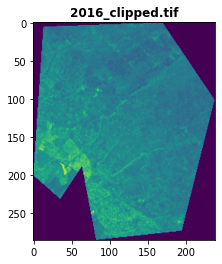

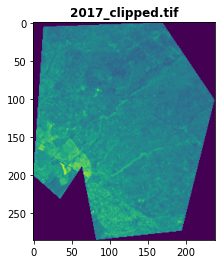

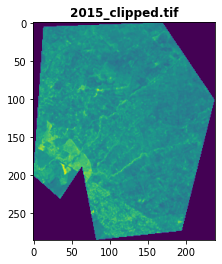

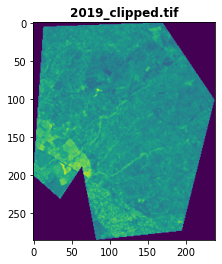

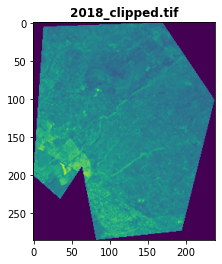

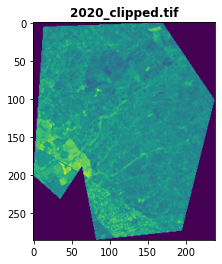

In [12]:
for name, data in clipped_rasters.items():
    show(data['image'][3], title=name)

### 2. True-color RGB

#### Edit Jupyter parameters to increase image size

In [13]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10, 10)

#### Extract bands and normalizing arrays in range 0-1 for plotting

In [14]:
rastr2020 = clipped_rasters['2020_clipped.tif']['image']
rastr2020_meta = clipped_rasters['2020_clipped.tif']['meta']

rastr2020_rgb = 'data/clipped/2020_true_color_clipped.tif'

In [15]:
rastr2020_meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 239,
 'height': 286,
 'count': 7,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00026949458523585647, 0.0, 37.50017153556943,
        0.0, -0.00026949458523585647, -2.9038041559163537)}

In [16]:
def normalize(input_band: np.array, in_range: tuple):
    min_range_val, max_range_val = in_range
    return (max_range_val * (input_band - input_band.min()) / np.ptp(input_band)) - min_range_val

blue_band = normalize(rastr2020[0], in_range=(0, 1))
green_band = normalize(rastr2020[1], in_range=(0, 1))
red_band = normalize(rastr2020[2], in_range=(0, 1))

rgb = np.dstack([red_band, green_band, blue_band])

#### Plot image in natural colors, RGB

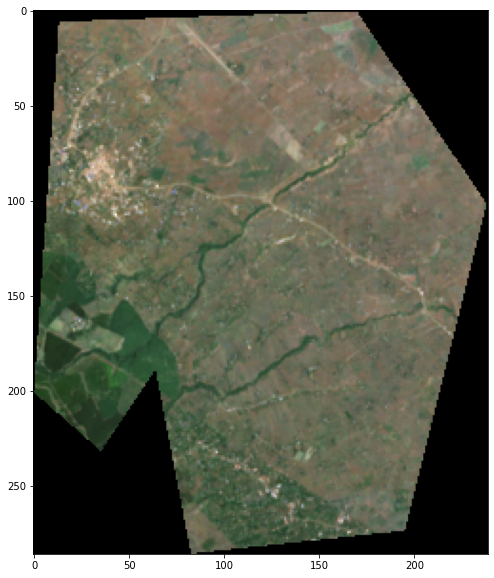

In [17]:
plt.imshow(rgb)

#### Write RGB image to GeoTiff file

In [18]:
blue_band_255 = normalize(rastr2020[0], in_range=(0, 255))
green_band_255 = normalize(rastr2020[1], in_range=(0, 255))
red_band_255 = normalize(rastr2020[2], in_range=(0, 255))

rgb_255 = np.dstack([red_band_255, green_band_255, blue_band_255])

rastr2020_meta.update({
    "dtype": rasterio.uint8,
    "count": 3,
})

with rasterio.open(rastr2020_rgb, 'w', **rastr2020_meta) as f:
    print(rgb_255.shape)
    raster = np.moveaxis(rgb_255, [0, 1, 2], [1, 2, 0])
    f.write(raster.astype(rasterio.uint8))

(286, 239, 3)


#### Check result

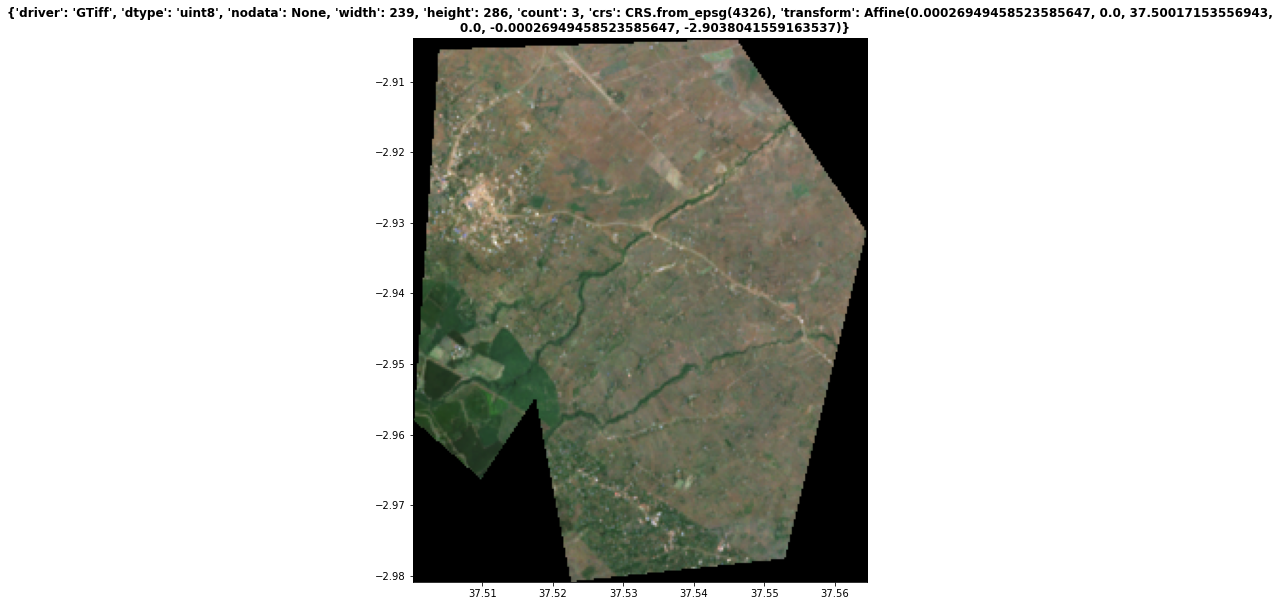

In [13]:
with rasterio.open(rastr2020_rgb, 'r') as f:
    show(f, title=f.meta)

### 3. NDVI

According to information about source data, pixels contain surface reflectance values. Therefore, we don't need to preprocess source data for calculating NDVI. Link with info about source images: https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR#bands 

In [14]:
def ndvi(red, nir):
    # red[red == 0], nir[nir == 0] = np.nan, np.nan
    return (nir - red) / (nir + red)

ndvi_mean = dict()

for name, data in clipped_rasters.items():
    red, nir = data['image'][2], data['image'][3]
    ndvi_mean[int(name[:4])] = ndvi(red[red > 0], nir[nir > 0]).mean()

In [15]:
sorted_ndvi_mean = sorted(ndvi_mean.items(), key=lambda x: x[0])
sorted_ndvi_mean

[(2015, 0.5164375177673322),
 (2016, 0.4859511776584113),
 (2017, 0.5094763093231403),
 (2018, 0.4875840075298388),
 (2019, 0.5278737061792486),
 (2020, 0.5182033406324481)]

#### Plot time series plot with mean NVDI by year

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


<AxesSubplot:>

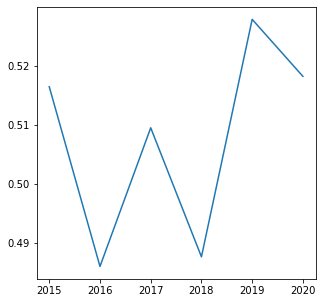

In [16]:
import seaborn as sns

mpl.rcParams['figure.figsize'] = (5, 5)
sns.lineplot(data=ndvi_mean)

#### Write csv file with NDVI values

In [17]:
import csv

NDVI_CSV = 'data/csv/ndvi_mean.csv'

with open(NDVI_CSV, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    
    writer.writerow(['year', 'ndvi_mean'])
    writer.writerows(sorted_ndvi_mean)

### 4. Upload csv file to S3

In [18]:
import boto3

s3 = boto3.resource('s3')

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


#### I will use my own S3 bucket to upload the CSV file. Uploading will be done by my user with attached "AmazonS3FullAccess" permission.

In [19]:
for bucket in s3.buckets.all():
    print(bucket.name)

kot-andrei-sandbox
prefect-artifacts


#### Upload file to S3

I will add specific storage class for this file: Standard-Infrequent Access.

In [20]:
bucket = s3.Bucket('kot-andrei-sandbox')

s3_client = boto3.client("s3")
s3_client.upload_file(
    Filename=NDVI_CSV,
    Bucket=bucket.name, 
    Key=os.path.basename(NDVI_CSV),
    ExtraArgs = {
      'StorageClass': 'STANDARD_IA'
    }
)

#### Check file in S3

In [21]:
for item in bucket.objects.all():
    print(item)

s3.ObjectSummary(bucket_name='kot-andrei-sandbox', key='ndvi_mean.csv')


### 5. Merge Red bands from different images to one file

In [22]:
red_bands = [
    data['image'][2]
    for name, data in sorted(clipped_rasters.items(), key=lambda x: x[0])  # sort by year from 2015 to 2020
]

In [23]:
meta = clipped_rasters['2015_clipped.tif']['meta']
meta.update({
    'count': 6
})

In [24]:
RED_COMPOSITE = 'data/clipped/red_composite.tif'

raster = np.dstack(red_bands)

with rasterio.open(RED_COMPOSITE, 'w', **meta) as f:
    raster = np.moveaxis(raster, [0, 1, 2], [1, 2, 0])
    f.write(raster)

### 6. Total area of clipped region

We have already the AOI geometry and can use this to calculate geodesic area in m2 by pyproj.

In [25]:
from pyproj import Geod
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import orient

geod = Geod(ellps='WGS84')

total_area = 0
for geom in aoi:
    if geom['type'] == 'Polygon':
        poly = orient(Polygon(geom['coordinates'][0]))
        geom_area, geom_perimeter = geod.geometry_area_perimeter(poly)
        total_area += geom_area
    else:
        raise NotImplementedError
    
print(f"Total area (vector): {round(total_area, 3)} m2")

Total area (vector): 46589316.324 m2


#### Calculate area only with raster:

We need to reproject raster to projection with planar coordinates and adopted for measurements. We can use UTM. 
Let's find appropriate UTM zone

In [26]:
from pyproj.database import query_utm_crs_info
from pyproj.aoi import AreaOfInterest

raster = rasterio.open('data/clipped/2015_clipped.tif')

In [27]:
from pyproj import CRS

utms = query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest=AreaOfInterest(
        west_lon_degree=raster.bounds.left,
        south_lat_degree=raster.bounds.bottom,
        east_lon_degree=raster.bounds.right,
        north_lat_degree=raster.bounds.top,
    ),
)

utm_proj = CRS.from_epsg(utms[0].code)
utm_proj

<Derived Projected CRS: EPSG:32737>
Name: WGS 84 / UTM zone 37S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 36°E and 42°E, southern hemisphere between 80°S and equator, onshore and offshore. Kenya. Mozambique. Tanzania.
- bounds: (36.0, -80.0, 42.0, 0.0)
Coordinate Operation:
- name: UTM zone 37S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Reprojection to UTM zone 37S

In [28]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

RED_COMPOSITE_UTM = 'data/clipped/red_composite_utm.tif'
dst_crs = utm_proj.to_string()

with rasterio.open(RED_COMPOSITE, 'r') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rasterio.open('data/clipped/red_composite_utm.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)


In [29]:
pixel_size_x, pixel_size_y = transform[0], -transform[4]
utm_raster = rasterio.open(RED_COMPOSITE_UTM)

data = utm_raster.read(1)
total_area_raster = np.count_nonzero(data) * pixel_size_x * pixel_size_y
print(f"Total area (raster): {round(total_area_raster, 3)} m2")

Total area (raster): 46680043.644 m2


The difference between total area on vector and raster related to not accurate outer boundary of raster. Pixels have their own sizes and these sizes must be infinitesimal in order to accurately calculate the area. 

Also, the area of the vector was calculated on the ellipsoid (WGS84) in a geodetic way, but the area of the raster was calculated in the UTM projection.